## XGBoost

Der gesamte Code ist derslebe, wie bei der Random Forest ANalyse, einfach mit dem anderen Modell, für das definieren der Funktion wurde zur Hilfe ChatGPT verwendet, und auch für das erstellen der Heatmap.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# define the path for our data
path = "/Users/alexandragort/Documents/Uni/BA&DSA/"
df_sta = pd.read_csv(path + "/sta_data.csv", low_memory=False)
df_sta

,datetime,Luftdruck_STA,Lufttemp_STA,Windgeschw_STA,StampfenbachstrOzon,AnzFahrzeuge_STA,hour_of_day,day_of_week,day_of_year,month,year
0,2021-01-01 01:00:00,954.0,2.1,4.7,8.51,1320.0,1,5,1,1,2021
1,2021-01-01 02:00:00,954.4,2.3,3.2,5.34,919.0,2,5,1,1,2021
2,2021-01-01 03:00:00,954.6,2.0,2.5,7.54,617.0,3,5,1,1,2021
3,2021-01-01 04:00:00,954.6,2.3,2.2,31.30,445.0,4,5,1,1,2021
4,2021-01-01 05:00:00,954.8,2.3,2.9,40.87,371.0,5,5,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...
25530,2023-11-30 19:00:00,948.9,3.2,2.9,2.90,2742.0,19,4,334,11,2023
25531,2023-11-30 20:00:00,948.9,3.8,5.4,1.99,2357.0,20,4,334,11,2023
25532,2023-11-30 21:00:00,949.1,4.3,6.8,3.28,1946.0,21,4,334,11,2023
25533,2023-11-30 22:00:00,949.2,3.8,5.4,6.96,1808.0,22,4,334,11,2023


# XGBoost Test aufgrund von negativen Werten

In [3]:
# setting 'datetime' as index
df_sta['datetime'] = pd.to_datetime(df_sta['datetime'])
df_sta.set_index('datetime', inplace=True)

In [4]:
test = df_sta[-8640:] # get last year
train = df_sta[0:-8640] # get data until first day of testing day

In [5]:
shifts = [24, 48, 72] #define shifts for 24, 48 and 72 hours

In [6]:
# Creating lags for each defined shifts
shifted_data = {"lag_{}_hour".format(hour_shift): train["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts}

# Creating a dataframe out of the shifted data
shifted_data = pd.DataFrame(shifted_data)
shifted_data

,lag_24_hour,lag_48_hour,lag_72_hour
datetime,,,
2021-01-01 01:00:00,NaN,NaN,NaN
2021-01-01 02:00:00,NaN,NaN,NaN
2021-01-01 03:00:00,NaN,NaN,NaN
2021-01-01 04:00:00,NaN,NaN,NaN
2021-01-01 05:00:00,NaN,NaN,NaN
...,...,...,...
2022-12-05 19:00:00,2.01,16.37,1.86
2022-12-05 20:00:00,1.86,14.35,2.94
2022-12-05 21:00:00,3.06,12.68,1.99


In [7]:
# concatenating the shifted data with our training data
train = pd.concat([train,shifted_data],axis=1)
train

,Luftdruck_STA,Lufttemp_STA,Windgeschw_STA,StampfenbachstrOzon,AnzFahrzeuge_STA,hour_of_day,day_of_week,day_of_year,month,year,lag_24_hour,lag_48_hour,lag_72_hour
datetime,,,,,,,,,,,,,
2021-01-01 01:00:00,954.0,2.1,4.7,8.51,1320.0,1,5,1,1,2021,NaN,NaN,NaN
2021-01-01 02:00:00,954.4,2.3,3.2,5.34,919.0,2,5,1,1,2021,NaN,NaN,NaN
2021-01-01 03:00:00,954.6,2.0,2.5,7.54,617.0,3,5,1,1,2021,NaN,NaN,NaN
2021-01-01 04:00:00,954.6,2.3,2.2,31.30,445.0,4,5,1,1,2021,NaN,NaN,NaN
2021-01-01 05:00:00,954.8,2.3,2.9,40.87,371.0,5,5,1,1,2021,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,968.6,5.7,3.6,22.99,2781.0,19,1,339,12,2022,2.01,16.37,1.86
2022-12-05 20:00:00,968.9,5.3,2.9,22.99,2204.0,20,1,339,12,2022,1.86,14.35,2.94
2022-12-05 21:00:00,969.0,4.4,3.6,12.72,2209.0,21,1,339,12,2022,3.06,12.68,1.99


In [8]:
#dropping nan-values
train = train.dropna()

In [9]:
# splitting the training data
X_train = train.drop("StampfenbachstrOzon", axis=1)
y_train = train["StampfenbachstrOzon"]

In [10]:
#import numpy as np
#from sklearn.metrics import mean_squared_error
history = train
#hourly_performance_collector = []
#performance_collector = []

In [11]:
# training the xgb regressor with 2000 estimators because that gave us the smallest negative predictions as you will see below

forecast_xgb_sta = xgb.XGBRegressor(n_estimators=2000, random_state=1)
forecast_xgb_sta.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [12]:
# Assuming df_sta is your DataFrame and you want to predict 'StampfenbachstrOzon'
#test = df_sta[-8640:]  # get last year

# Erstellen Sie nur Lag-Werte für die angegebenen Schichten (for the test set)
#shifts = [24, 48, 72]
#shifted_data_test = {"lag_{}_hour".format(hour_shift): test["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts}

# Erstellen Sie ein DataFrame aus den verschobenen Daten (for the test set)
#shifted_data_test = pd.DataFrame(shifted_data_test)
#test = pd.concat([test, shifted_data_test], axis=1)
#test = test.dropna()

# Assuming forecast_xgb_sta is already trained
#y_pred_test = forecast_xgb_sta.predict(test.drop("StampfenbachstrOzon", axis=1))

# Print or use y_pred_test as needed
#print(y_pred_test)



In [13]:
#test['Predicted_StampfenbachstrOzon'] = y_pred_test

# Print or use the test dataset with predictions as needed
#test

In [14]:
#testing for negative values
#negative_values = test[test['Predicted_StampfenbachstrOzon'] < 0]

# Display rows with negative values (if any)
#print("Rows with negative values in 'test_data':")
#print(negative_values)

Wir können hier sehen, dass einige Predictions negativ sind, das liegt vermutlich daran, es innnerhalb der Daten einen absteigenden Trend gibt. 
Die negativen Werte werden wir deshalb  mit der .clip Methode auf null setzen.  https://blog.quant-aq.com/why-is-my-air-quality-monitor-reporting-negative-values-and-what-can-i-do-about-it/#:~:text=Seeing%20a%20negative%20value%20in,can%20you%20do%20about%20it%3F

In [15]:
#test['Predicted_StampfenbachstrOzon'] = test['Predicted_StampfenbachstrOzon'].clip(lower=0)

# Print or use the modified test dataset with predictions
#test


Dieser code war nur um zu testen, dass die negativen Predictions nicht aufgrund des Walking forwards passieren - was nicht der Fall war, es passiert offensichtlich auch sonst, wir verwenden den Code jedoch nicht weiter.

In [16]:
#Definieren einer Funktion für Walking forwad VAlidation des XGB Models auf dem test set
def Walk_forward_validationXGB(history, test, forecast_model, shifts):
    """
    Diese Funktion evaluiert die Performance des XGB Models auf dem Test Data-Set.
    Der Output sind die upgedateten historischen Daten sowie die negative Predictions des Models.
    """

    # Empty list to store the negatives
    negative_values_info = []

    # Iteration ofer unique days in the testset
    for d in test["day_of_year"].unique():
        # Accessing last 24 hrs
        dat = history.tail(72)
        # Concatenate the data 
        dat = pd.concat([dat, test[test["day_of_year"] == d]])
        # lagged features
        shifted_data = {"lag_{}_hour".format(hour_shift): dat["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts}
        shifted_data = pd.DataFrame(shifted_data)
        # Concatenate original features with lagged features
        dat = pd.concat([dat[["Luftdruck_STA", "Lufttemp_STA", "Windgeschw_STA", "StampfenbachstrOzon", "AnzFahrzeuge_STA", "hour_of_day", "day_of_week", "day_of_year", "month", "year"]], shifted_data], axis=1)
        # Drop rows with nan-values
        dat = dat.dropna()
        # Dropping target
        pred_dat = dat.drop("StampfenbachstrOzon", axis=1)
        # make predictions
        y_pred = forecast_xgb_sta.predict(pred_dat)
        # Get the actual target variable values from the test data for the current day
        actual = test[test["day_of_year"] == d]["StampfenbachstrOzon"]

        # Defining MSE for evaluation
        for h in range(24):
            actual_hourly = test[(test["hour_of_day"] == h) & (test["day_of_year"] == d)]["StampfenbachstrOzon"]
            y_pred_hourly = y_pred[h::24]  # Extract predictions for the current hour from the 24-hour prediction
            # Printing y_pred_hourly
            print(f'Day {d}, Hour {h}, y_pred_hourly: {y_pred_hourly.tolist()}')
            # Checking for negative predicitons made by the model
            if any(value < 0 for value in y_pred_hourly):
                negative_values_info.append((d, h, y_pred_hourly.tolist()))
    # Display megative preds
    for info in negative_values_info:
        print(f'Negative values found in y_pred_hourly for Day {info[0]}, Hour {info[1]}: {info[2]}')
    # Concatenate the current days data to historical data
    history = pd.concat([history, dat], ignore_index=True)

    return history

# Quelle: für Funktion und hinzufügen der negative Values: Chat GPT

In [17]:
#calling the function
history = Walk_forward_validationXGB(history, test, forecast_xgb_sta, shifts)

Day 340, Hour 0, y_pred_hourly: [-0.11529191583395004]
Day 340, Hour 1, y_pred_hourly: [6.786739826202393]
Day 340, Hour 2, y_pred_hourly: [15.501468658447266]
Day 340, Hour 3, y_pred_hourly: [14.548022270202637]
Day 340, Hour 4, y_pred_hourly: [11.91012954711914]
Day 340, Hour 5, y_pred_hourly: [12.556721687316895]
Day 340, Hour 6, y_pred_hourly: [13.369505882263184]
Day 340, Hour 7, y_pred_hourly: [5.6622233390808105]
Day 340, Hour 8, y_pred_hourly: [7.043752670288086]
Day 340, Hour 9, y_pred_hourly: [6.3553147315979]
Day 340, Hour 10, y_pred_hourly: [9.444981575012207]
Day 340, Hour 11, y_pred_hourly: [12.89277172088623]
Day 340, Hour 12, y_pred_hourly: [19.28347396850586]
Day 340, Hour 13, y_pred_hourly: [28.27303695678711]
Day 340, Hour 14, y_pred_hourly: [19.831857681274414]
Day 340, Hour 15, y_pred_hourly: [18.97355842590332]
Day 340, Hour 16, y_pred_hourly: [18.959388732910156]
Day 340, Hour 17, y_pred_hourly: [9.374055862426758]
Day 340, Hour 18, y_pred_hourly: [12.26596927642

Wie wir hier sehen, gibt es auch mit Walking-Forward noch weiterhin negative Werte, deshalb haben wir uns schlussendlich für das Random Forest Modell entschieden, da dies dort nicht passiert ist.

### Visualisierung

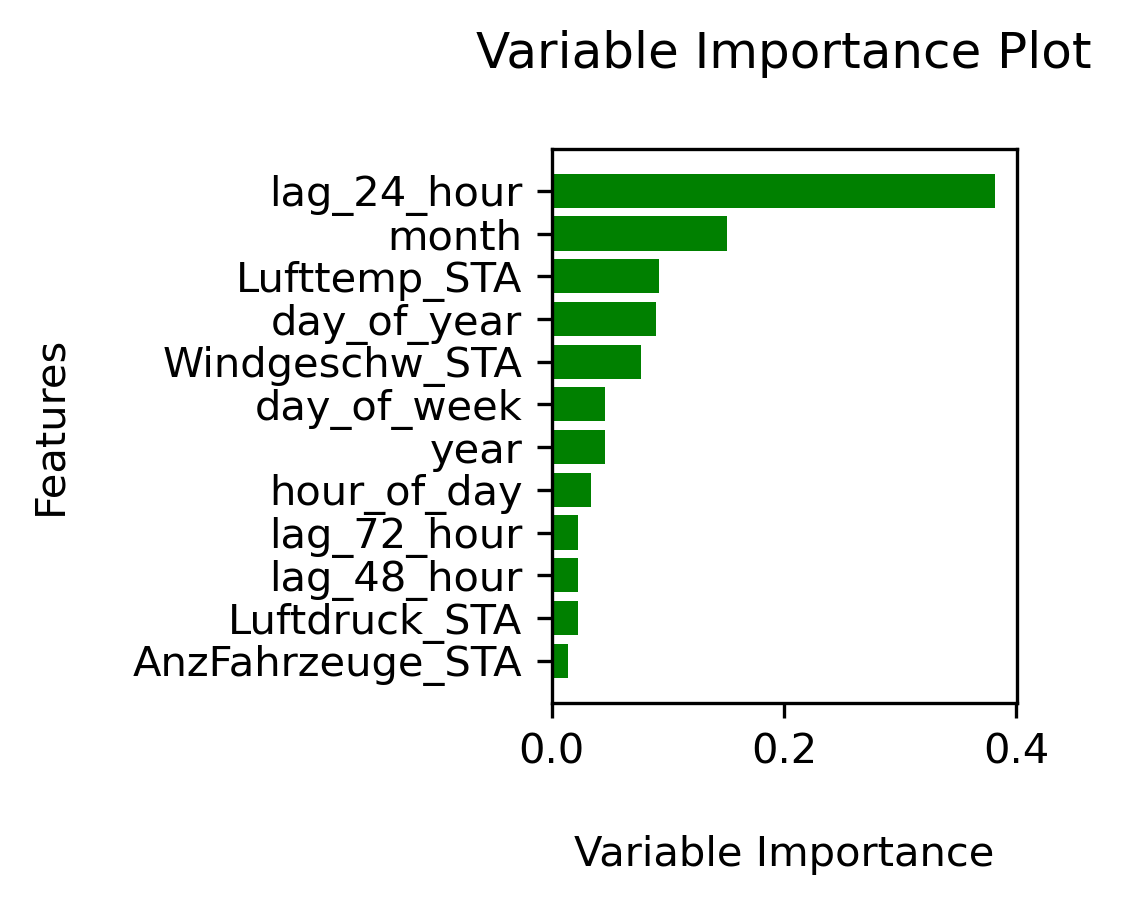

In [18]:
import xgboost as xgb 
import pandas as pd
import matplotlib.pyplot as plt

#Feature Importance Plot vom Unterrichtsnotebook
def plot_variable_importance_xgb(model, X_train):
    feature_names = X_train.columns
    importance_scores = model.feature_importances_
    imp = pd.DataFrame({"imp": importance_scores, "names": feature_names}).sort_values("imp", ascending=True)
    
    
    fig, ax = plt.subplots(figsize=(imp.shape[0] / 6, imp.shape[0] / 5), dpi=300)
    ax.barh(imp["names"], imp["imp"], color="green")
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n')
    ax.set_title('Variable Importance Plot\n')
    plt.show()

plot_variable_importance_xgb(forecast_xgb_sta, X_train)



Hier können wir sehen, dass lag_24_hour ein sehr wichtiges Feature für unsere Prediction ist, und wie man erwarten konnte, einen grossen Einfluss auf unsere Prediction hat. Dies reflektiert das "Tages-Pattern" in unseren TimeSeries Daten. Die beiden anderen lags 48 und 72 haben eine kleinere "Importance" was darauf hindeuted, dass die kurzfristige vergangenheit sehr relevant ist für die Prediction und das Model ist sehr sensibel auf verschiedene Zeit-Intervalle. Des Weiteren haben auch der Monat und die Lufttemperatur einen hohen Einfluss auf die Prediciton des Ozons.

Correlation Matrix:
             lag_24_hour  lag_48_hour  lag_72_hour
lag_24_hour     1.000000     0.747936     0.657751
lag_48_hour     0.747936     1.000000     0.747471
lag_72_hour     0.657751     0.747471     1.000000


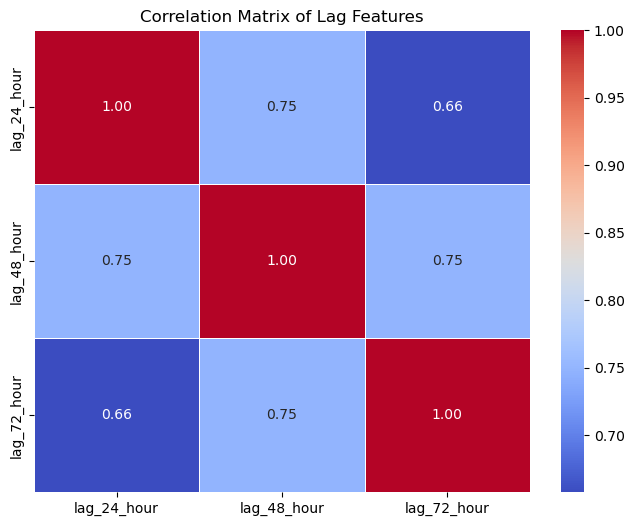

In [19]:
# Assuming lag features are stored in a DataFrame called lagged_data
lagged_data_corr = train[['lag_24_hour', 'lag_48_hour', 'lag_72_hour']].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(lagged_data_corr)

# Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(lagged_data_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Lag Features')
plt.show()
#Quelle: Chat GPT: Prompt: give me the correlation matrix of the lagged features

Hier können wir sehen, dass die lag-features zum Teil miteinander korrelieren, womöglich hat das Model deshalb lag-24_hour priorisiert und deshalb hat dieses eine sehr hohe "importance", während die anderen beiden lags ziemlich wenig "importance" haben.

# 72 Studen Lags und N_Estimators 200

In [20]:
#The code was taken from the Forecasting Notebook of Module 8
def evaluate_forecast(train, test, shifts, train_tail, model):
    history = train.copy()
    hourly_predictions_df = pd.DataFrame(columns=['Day', 'Hour', 'Predicted_Ozon', 'Actual_Ozon'])
    performance_collector = []


    for d in test["day_of_year"].unique():
        dat = history.tail(train_tail)  # get last 72 hours of available data
        dat = pd.concat([dat, test[test["day_of_year"] == d]])  # add test data

        shifted_data = {"lag_{}_hour".format(hour_shift): dat["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts}  # lag training data
        shifted_data = pd.DataFrame(shifted_data)

        dat = pd.concat([dat[["Luftdruck_STA", "Lufttemp_STA", "Windgeschw_STA", "StampfenbachstrOzon", "AnzFahrzeuge_STA", "hour_of_day", "day_of_week", "day_of_year", "month", "year"]], shifted_data], axis=1)
        
        dat = dat.dropna()  # delete missing data

        pred_dat = dat.drop("StampfenbachstrOzon", axis=1)

        y_pred = model.predict(pred_dat)
        actual = test[test["day_of_year"] == d]["StampfenbachstrOzon"]
        
        for h in range(24):
            actual_hourly = test[(test["hour_of_day"] == h) & (test["day_of_year"] == d)]["StampfenbachstrOzon"]
            y_pred_hourly = y_pred[h::24]  # Extract predictions for the current hour from the 24-hour prediction
            print(f'Day {d}, Hour {h}, y_pred_hourly: {y_pred_hourly.tolist()}')
            hourly_predictions_df = pd.concat([hourly_predictions_df, pd.DataFrame({"Day": [d], "Hour": [h], "Predicted_Ozon": [y_pred_hourly.tolist()], "Actual_Ozon": [actual_hourly.tolist()]})], ignore_index=True)
        
        
        performance_collector.append(mean_squared_error(actual, y_pred, squared=False))

        history = pd.concat([history, dat], ignore_index=True)

    return performance_collector, hourly_predictions_df

In [21]:
def plot_variable_importance(model, X_train):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp=DataFrame({"imp":model.feature_importances_, "names":X_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(imp.shape[0]/6,imp.shape[0]/5), dpi=300) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show() 

In [22]:
df_sta = pd.read_csv(path + "sta_data.csv", low_memory=False)
df_sta

,datetime,Luftdruck_STA,Lufttemp_STA,Windgeschw_STA,StampfenbachstrOzon,AnzFahrzeuge_STA,hour_of_day,day_of_week,day_of_year,month,year
0,2021-01-01 01:00:00,954.0,2.1,4.7,8.51,1320.0,1,5,1,1,2021
1,2021-01-01 02:00:00,954.4,2.3,3.2,5.34,919.0,2,5,1,1,2021
2,2021-01-01 03:00:00,954.6,2.0,2.5,7.54,617.0,3,5,1,1,2021
3,2021-01-01 04:00:00,954.6,2.3,2.2,31.30,445.0,4,5,1,1,2021
4,2021-01-01 05:00:00,954.8,2.3,2.9,40.87,371.0,5,5,1,1,2021
...,...,...,...,...,...,...,...,...,...,...,...
25530,2023-11-30 19:00:00,948.9,3.2,2.9,2.90,2742.0,19,4,334,11,2023
25531,2023-11-30 20:00:00,948.9,3.8,5.4,1.99,2357.0,20,4,334,11,2023
25532,2023-11-30 21:00:00,949.1,4.3,6.8,3.28,1946.0,21,4,334,11,2023
25533,2023-11-30 22:00:00,949.2,3.8,5.4,6.96,1808.0,22,4,334,11,2023


In [23]:
df_sta['datetime'] = pd.to_datetime(df_sta['datetime'])
df_sta.set_index('datetime', inplace=True)

In [24]:
test1 = df_sta[-8640:] # get last year
train1 = df_sta[0:-8640] # get data until first day of testing day

In [25]:
shifts1 = np.arange(24, 73).astype(int) #we set lags from 24 to 72 (1 day and 3 days)

In [26]:
# Erstellen Sie nur Lag-Werte für die angegebenen Schichten
shifted_data1 = {"lag_{}_hour".format(hour_shift): train1["StampfenbachstrOzon"].shift(hour_shift) for hour_shift in shifts1}

# Erstellen Sie ein DataFrame aus den verschobenen Daten
shifted_data1 = pd.DataFrame(shifted_data1)
shifted_data1

,lag_24_hour,lag_25_hour,lag_26_hour,lag_27_hour,lag_28_hour,lag_29_hour,lag_30_hour,lag_31_hour,lag_32_hour,lag_33_hour,...,lag_63_hour,lag_64_hour,lag_65_hour,lag_66_hour,lag_67_hour,lag_68_hour,lag_69_hour,lag_70_hour,lag_71_hour,lag_72_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,2.01,2.29,2.33,2.75,5.11,6.95,7.03,6.65,6.37,5.79,...,9.42,8.94,8.56,3.80,2.48,2.89,1.83,1.99,2.94,1.86
2022-12-05 20:00:00,1.86,2.01,2.29,2.33,2.75,5.11,6.95,7.03,6.65,6.37,...,10.09,9.42,8.94,8.56,3.80,2.48,2.89,1.83,1.99,2.94
2022-12-05 21:00:00,3.06,1.86,2.01,2.29,2.33,2.75,5.11,6.95,7.03,6.65,...,10.67,10.09,9.42,8.94,8.56,3.80,2.48,2.89,1.83,1.99


In [27]:
#We create our training set with the shifted data
train1 = pd.concat([train1,shifted_data1],axis=1)
train1

,Luftdruck_STA,Lufttemp_STA,Windgeschw_STA,StampfenbachstrOzon,AnzFahrzeuge_STA,hour_of_day,day_of_week,day_of_year,month,year,...,lag_63_hour,lag_64_hour,lag_65_hour,lag_66_hour,lag_67_hour,lag_68_hour,lag_69_hour,lag_70_hour,lag_71_hour,lag_72_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,954.0,2.1,4.7,8.51,1320.0,1,5,1,1,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,954.4,2.3,3.2,5.34,919.0,2,5,1,1,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00,954.6,2.0,2.5,7.54,617.0,3,5,1,1,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 04:00:00,954.6,2.3,2.2,31.30,445.0,4,5,1,1,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 05:00:00,954.8,2.3,2.9,40.87,371.0,5,5,1,1,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,968.6,5.7,3.6,22.99,2781.0,19,1,339,12,2022,...,9.42,8.94,8.56,3.80,2.48,2.89,1.83,1.99,2.94,1.86
2022-12-05 20:00:00,968.9,5.3,2.9,22.99,2204.0,20,1,339,12,2022,...,10.09,9.42,8.94,8.56,3.80,2.48,2.89,1.83,1.99,2.94
2022-12-05 21:00:00,969.0,4.4,3.6,12.72,2209.0,21,1,339,12,2022,...,10.67,10.09,9.42,8.94,8.56,3.80,2.48,2.89,1.83,1.99


In [28]:
#We drop the NaN values
train1 = train1.dropna()

In [29]:
#We create our X_train and y_train sets
X_train1 = train1.drop("StampfenbachstrOzon", axis=1)
y_train1 = train1["StampfenbachstrOzon"]

In [30]:
#We fit our model
forecast_xgb_sta1 = xgb.XGBRegressor(n_estimators=200, random_state=1)
forecast_xgb_sta1.fit(X_train1, y_train1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [31]:
#We apply our forecasting function
performance_collector1, predictions_df1 = evaluate_forecast(train1, test1, shifts1, 72, forecast_xgb_sta1)

Day 340, Hour 0, y_pred_hourly: [3.5361876487731934]
Day 340, Hour 1, y_pred_hourly: [8.40002727508545]
Day 340, Hour 2, y_pred_hourly: [8.039870262145996]
Day 340, Hour 3, y_pred_hourly: [6.561290740966797]
Day 340, Hour 4, y_pred_hourly: [7.626410961151123]
Day 340, Hour 5, y_pred_hourly: [9.102764129638672]
Day 340, Hour 6, y_pred_hourly: [11.91246509552002]
Day 340, Hour 7, y_pred_hourly: [12.259236335754395]
Day 340, Hour 8, y_pred_hourly: [9.457291603088379]
Day 340, Hour 9, y_pred_hourly: [5.358962535858154]
Day 340, Hour 10, y_pred_hourly: [11.829065322875977]
Day 340, Hour 11, y_pred_hourly: [7.556988716125488]
Day 340, Hour 12, y_pred_hourly: [15.033133506774902]
Day 340, Hour 13, y_pred_hourly: [21.106157302856445]
Day 340, Hour 14, y_pred_hourly: [15.292675018310547]
Day 340, Hour 15, y_pred_hourly: [17.56291389465332]
Day 340, Hour 16, y_pred_hourly: [18.502622604370117]
Day 340, Hour 17, y_pred_hourly: [22.517528533935547]
Day 340, Hour 18, y_pred_hourly: [14.783676147460

In [32]:
#We print our mean performance collector
print(np.mean(performance_collector1))

16.281117099521794


In [33]:
#We print our predictions
print(predictions_df1)

      Day Hour        Predicted_Ozon Actual_Ozon
0     340    0  [3.5361876487731934]      [3.65]
1     340    1    [8.40002727508545]      [2.87]
2     340    2   [8.039870262145996]     [12.55]
3     340    3   [6.561290740966797]     [28.25]
4     340    4   [7.626410961151123]      [7.35]
...   ...  ...                   ...         ...
8635  334   19  [13.719804763793945]       [2.9]
8636  334   20   [29.17643928527832]      [1.99]
8637  334   21  [25.834938049316406]      [3.28]
8638  334   22  [24.823543548583984]      [6.96]
8639  334   23  [23.647960662841797]      [2.42]

[8640 rows x 4 columns]


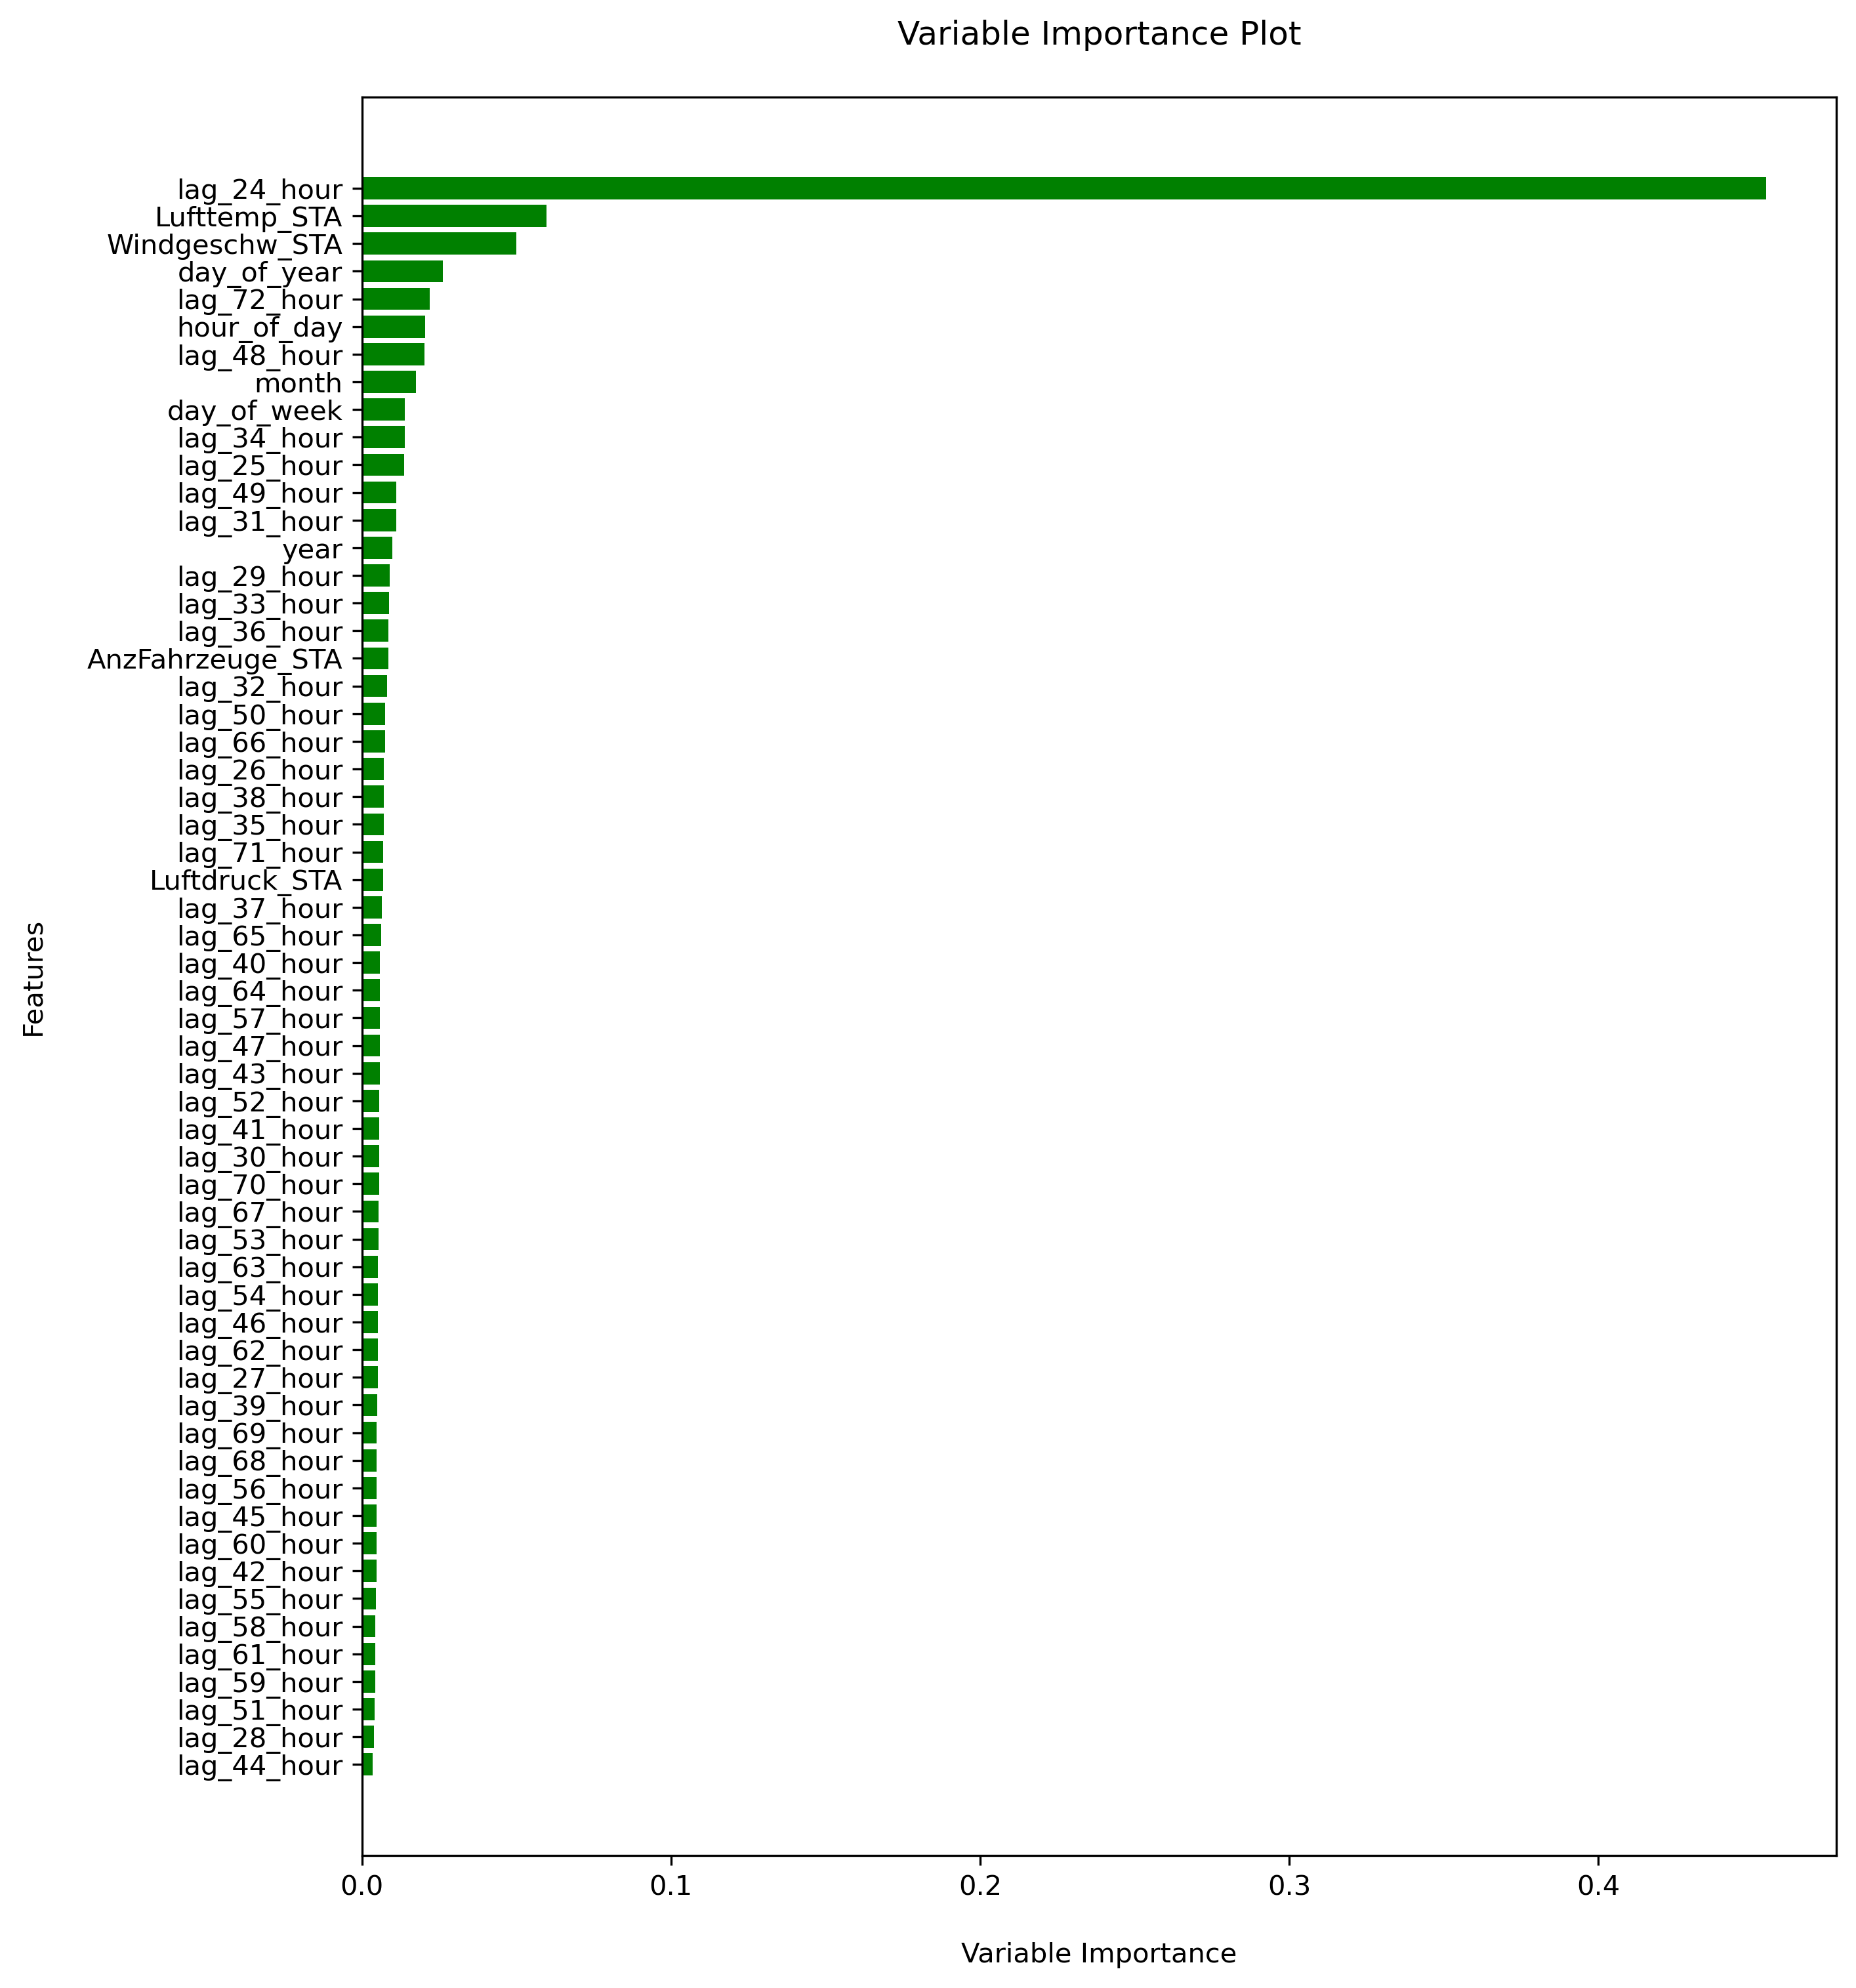

In [34]:
#We print our variable importance plot
plot_variable_importance(forecast_xgb_sta1, X_train1)

Aus dem Variable Importance Plot ergibt sich, dass die Variablen lag 24h, Lufttemperatur, Windgeschwindigkeit, day of the year und lag 72h am wichtigsten sind.

In [35]:
predictions_df1 = predictions_df1.explode('Predicted_Ozon')
predictions_df1 = predictions_df1.explode('Actual_Ozon')
# Reset the index
predictions_df1.reset_index(drop=True, inplace=True)

# Display the DataFrame after modification
print(predictions_df1)

      Day Hour Predicted_Ozon Actual_Ozon
0     340    0       3.536188        3.65
1     340    1       8.400027        2.87
2     340    2        8.03987       12.55
3     340    3       6.561291       28.25
4     340    4       7.626411        7.35
...   ...  ...            ...         ...
8635  334   19      13.719805         2.9
8636  334   20      29.176439        1.99
8637  334   21      25.834938        3.28
8638  334   22      24.823544        6.96
8639  334   23      23.647961        2.42

[8640 rows x 4 columns]


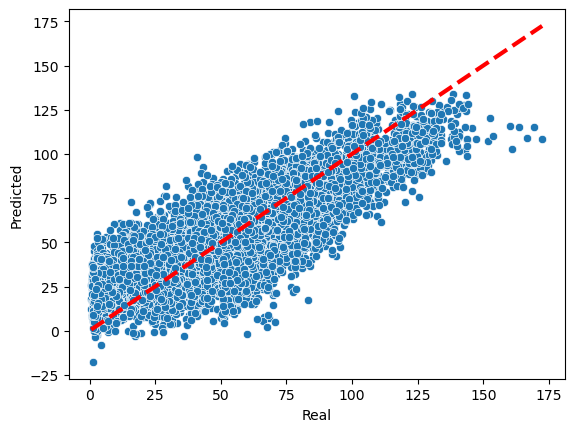

In [36]:
import seaborn as sns
#Visual representation of the results
data_rf1 = pd.DataFrame({'Real': predictions_df1['Actual_Ozon'], 'Predicted': predictions_df1['Predicted_Ozon']})

sns.scatterplot(data=data_rf1, x='Real', y='Predicted')
plt.plot([test1['StampfenbachstrOzon'].min(), test1['StampfenbachstrOzon'].max()], [test1['StampfenbachstrOzon'].min(), test1['StampfenbachstrOzon'].max()], 'r--', lw=3)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()